# **Comparative Analysis of Tree Ensemble Models for EEG Event Detection**

I am using data from a past Kaggle competition to train a model that can detect certain events from EEG brainwave data. The events would then trigger certain gestures in a prosthetic device for example, using BCI technology. My goal is to get perfect/near perfect predictions on the testing data. You can get more info on the contest/dataset [here](https://www.kaggle.com/c/grasp-and-lift-eeg-detection/)

## **Install The Libraries**
First we install install all necessary Python libraries. Check the [README.md](../README.md) file for more info on how to do this.

## **Kaggle Environment Setup**
You will need to upload your *kaggle.json*, set the permissions so the file can be read.

In [1]:
!chmod 600 ../kaggle.json

Then we set the Kaggle configuration directory to our current working directory, as an environment variable.

In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '../'

Now we can download the data from the competition page, 

In [3]:
if not os.path.exists('../data/kaggle-eeg'):
    os.makedirs('../data/kaggle-eeg')
    !kaggle competitions download grasp-and-lift-eeg-detection -p ../data/kaggle-eeg/ -f train.zip
    !unzip ../data/kaggle-eeg/train.zip -d ../data/kaggle-eeg

## **Imports**

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mne.decoding import CSP
from xgboost import XGBClassifier, plot_importance
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, hamming_loss, jaccard_score, multilabel_confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
import wandb
pd.set_option('display.max_columns', None)


## **Data Analysis**
First we load some of the training data and check the first few rows.

In [5]:
data_path = '../data/kaggle-eeg/train'
features = pd.read_csv(f'{data_path}/subj1_series1_data.csv')
labels = pd.read_csv(f'{data_path}/subj1_series1_events.csv')
features = features.drop(columns=['id'])
labels = labels.drop(columns=['id'])

display(features.info(), features.describe(), features.head(), labels.info(), labels.describe(), labels.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119496 entries, 0 to 119495
Data columns (total 32 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   Fp1     119496 non-null  int64
 1   Fp2     119496 non-null  int64
 2   F7      119496 non-null  int64
 3   F3      119496 non-null  int64
 4   Fz      119496 non-null  int64
 5   F4      119496 non-null  int64
 6   F8      119496 non-null  int64
 7   FC5     119496 non-null  int64
 8   FC1     119496 non-null  int64
 9   FC2     119496 non-null  int64
 10  FC6     119496 non-null  int64
 11  T7      119496 non-null  int64
 12  C3      119496 non-null  int64
 13  Cz      119496 non-null  int64
 14  C4      119496 non-null  int64
 15  T8      119496 non-null  int64
 16  TP9     119496 non-null  int64
 17  CP5     119496 non-null  int64
 18  CP1     119496 non-null  int64
 19  CP2     119496 non-null  int64
 20  CP6     119496 non-null  int64
 21  TP10    119496 non-null  int64
 22  P7      119496 non-n

None

,Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,C3,Cz,C4,T8,TP9,CP5,CP1,CP2,CP6,TP10,P7,P3,Pz,P4,P8,PO9,O1,Oz,O2,PO10
count,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000
mean,265.934374,404.173194,398.503774,215.615385,144.392189,443.437395,-122.864221,474.953538,88.350681,16.658583,325.775624,-72.496017,164.679822,8.043031,297.241439,296.862715,144.547608,-0.888189,112.011406,234.946877,27.035206,85.143754,450.076714,211.734401,188.356271,162.037800,368.885569,102.616556,305.008302,28.207438,67.214919,155.612497
std,373.911366,313.686274,207.645572,204.065055,141.130921,221.457186,479.160803,198.874064,113.654894,124.604345,317.959455,654.323615,160.777132,104.530898,141.144494,1281.825049,1166.903290,158.022883,159.564132,155.383882,233.517355,587.479539,222.096432,151.240938,189.787461,267.063408,248.232282,212.856072,202.580586,188.116823,256.458072,225.393451
min,-1051.000000,-532.000000,-752.000000,-466.000000,-262.000000,-634.000000,-4095.000000,-893.000000,-300.000000,-517.000000,-4119.000000,-4759.000000,-437.000000,-375.000000,-864.000000,-6541.000000,-1852.000000,-866.000000,-304.000000,-298.000000,-1848.000000,-3563.000000,-1283.000000,-378.000000,-427.000000,-1207.000000,-1057.000000,-908.000000,-666.000000,-822.000000,-888.000000,-948.000000
25%,43.000000,218.000000,253.000000,76.000000,37.000000,300.000000,-378.000000,341.000000,24.000000,-59.000000,124.000000,-337.000000,52.000000,-68.000000,207.000000,85.000000,-184.000000,-107.000000,4.000000,131.000000,-152.000000,-151.000000,304.000000,111.000000,68.000000,16.000000,213.000000,-41.000000,167.000000,-97.000000,-118.000000,15.000000
50%,210.000000,360.000000,389.000000,210.000000,123.000000,431.000000,-190.000000,469.000000,95.000000,15.000000,321.000000,-109.000000,167.000000,0.000000,281.000000,280.000000,38.000000,1.000000,86.000000,210.000000,33.000000,61.000000,445.000000,205.000000,161.000000,176.000000,361.000000,85.000000,307.000000,32.000000,45.000000,134.000000
75%,404.000000,515.000000,534.000000,356.000000,242.000000,566.000000,30.000000,606.000000,147.000000,93.000000,537.000000,143.000000,274.000000,77.000000,378.000000,508.000000,233.000000,102.000000,185.000000,315.000000,201.000000,263.000000,595.000000,307.000000,266.000000,346.000000,518.000000,232.000000,446.000000,154.000000,246.000000,264.000000
max,3101.000000,3047.000000,1479.000000,1253.000000,801.000000,2417.000000,5111.000000,3203.000000,545.000000,665.000000,9011.000000,4844.000000,969.000000,376.000000,2158.000000,11312.000000,8322.000000,865.000000,815.000000,907.000000,1736.000000,4184.000000,2088.000000,788.000000,1140.000000,879.000000,1400.000000,1611.000000,1074.000000,859.000000,978.000000,1326.000000


,Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,C3,Cz,C4,T8,TP9,CP5,CP1,CP2,CP6,TP10,P7,P3,Pz,P4,P8,PO9,O1,Oz,O2,PO10
0,-31,363,211,121,211,15,717,279,35,158,543,-166,192,230,573,860,128,59,272,473,325,379,536,348,383,105,607,289,459,173,120,704
1,-29,342,216,123,222,200,595,329,43,166,495,-138,201,233,554,846,185,47,269,455,307,368,529,327,369,78,613,248,409,141,83,737
2,-172,278,105,93,222,511,471,280,12,177,534,-163,198,207,542,768,145,52,250,452,273,273,511,319,355,66,606,320,440,141,62,677
3,-272,263,-52,99,208,511,428,261,27,180,525,-310,212,221,542,808,115,41,276,432,258,241,521,336,356,71,568,339,437,139,58,592
4,-265,213,-67,99,155,380,476,353,32,165,507,-320,242,230,545,865,180,89,288,444,275,275,550,324,346,76,547,343,446,171,67,581


None

,HandStart,FirstDigitTouch,BothStartLoadPhase,LiftOff,Replace,BothReleased
count,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000
mean,0.042679,0.042679,0.042679,0.042679,0.042679,0.042679
std,0.202134,0.202134,0.202134,0.202134,0.202134,0.202134
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,HandStart,FirstDigitTouch,BothStartLoadPhase,LiftOff,Replace,BothReleased
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


In [8]:
def load_series_data(subject, series):
    features = pd.read_csv(f'{data_path}/subj{subject}_series{series}_data.csv')
    labels = pd.read_csv(f'{data_path}/subj{subject}_series{series}_events.csv')
    return features, labels

features, labels = load_series_data(1, 1)

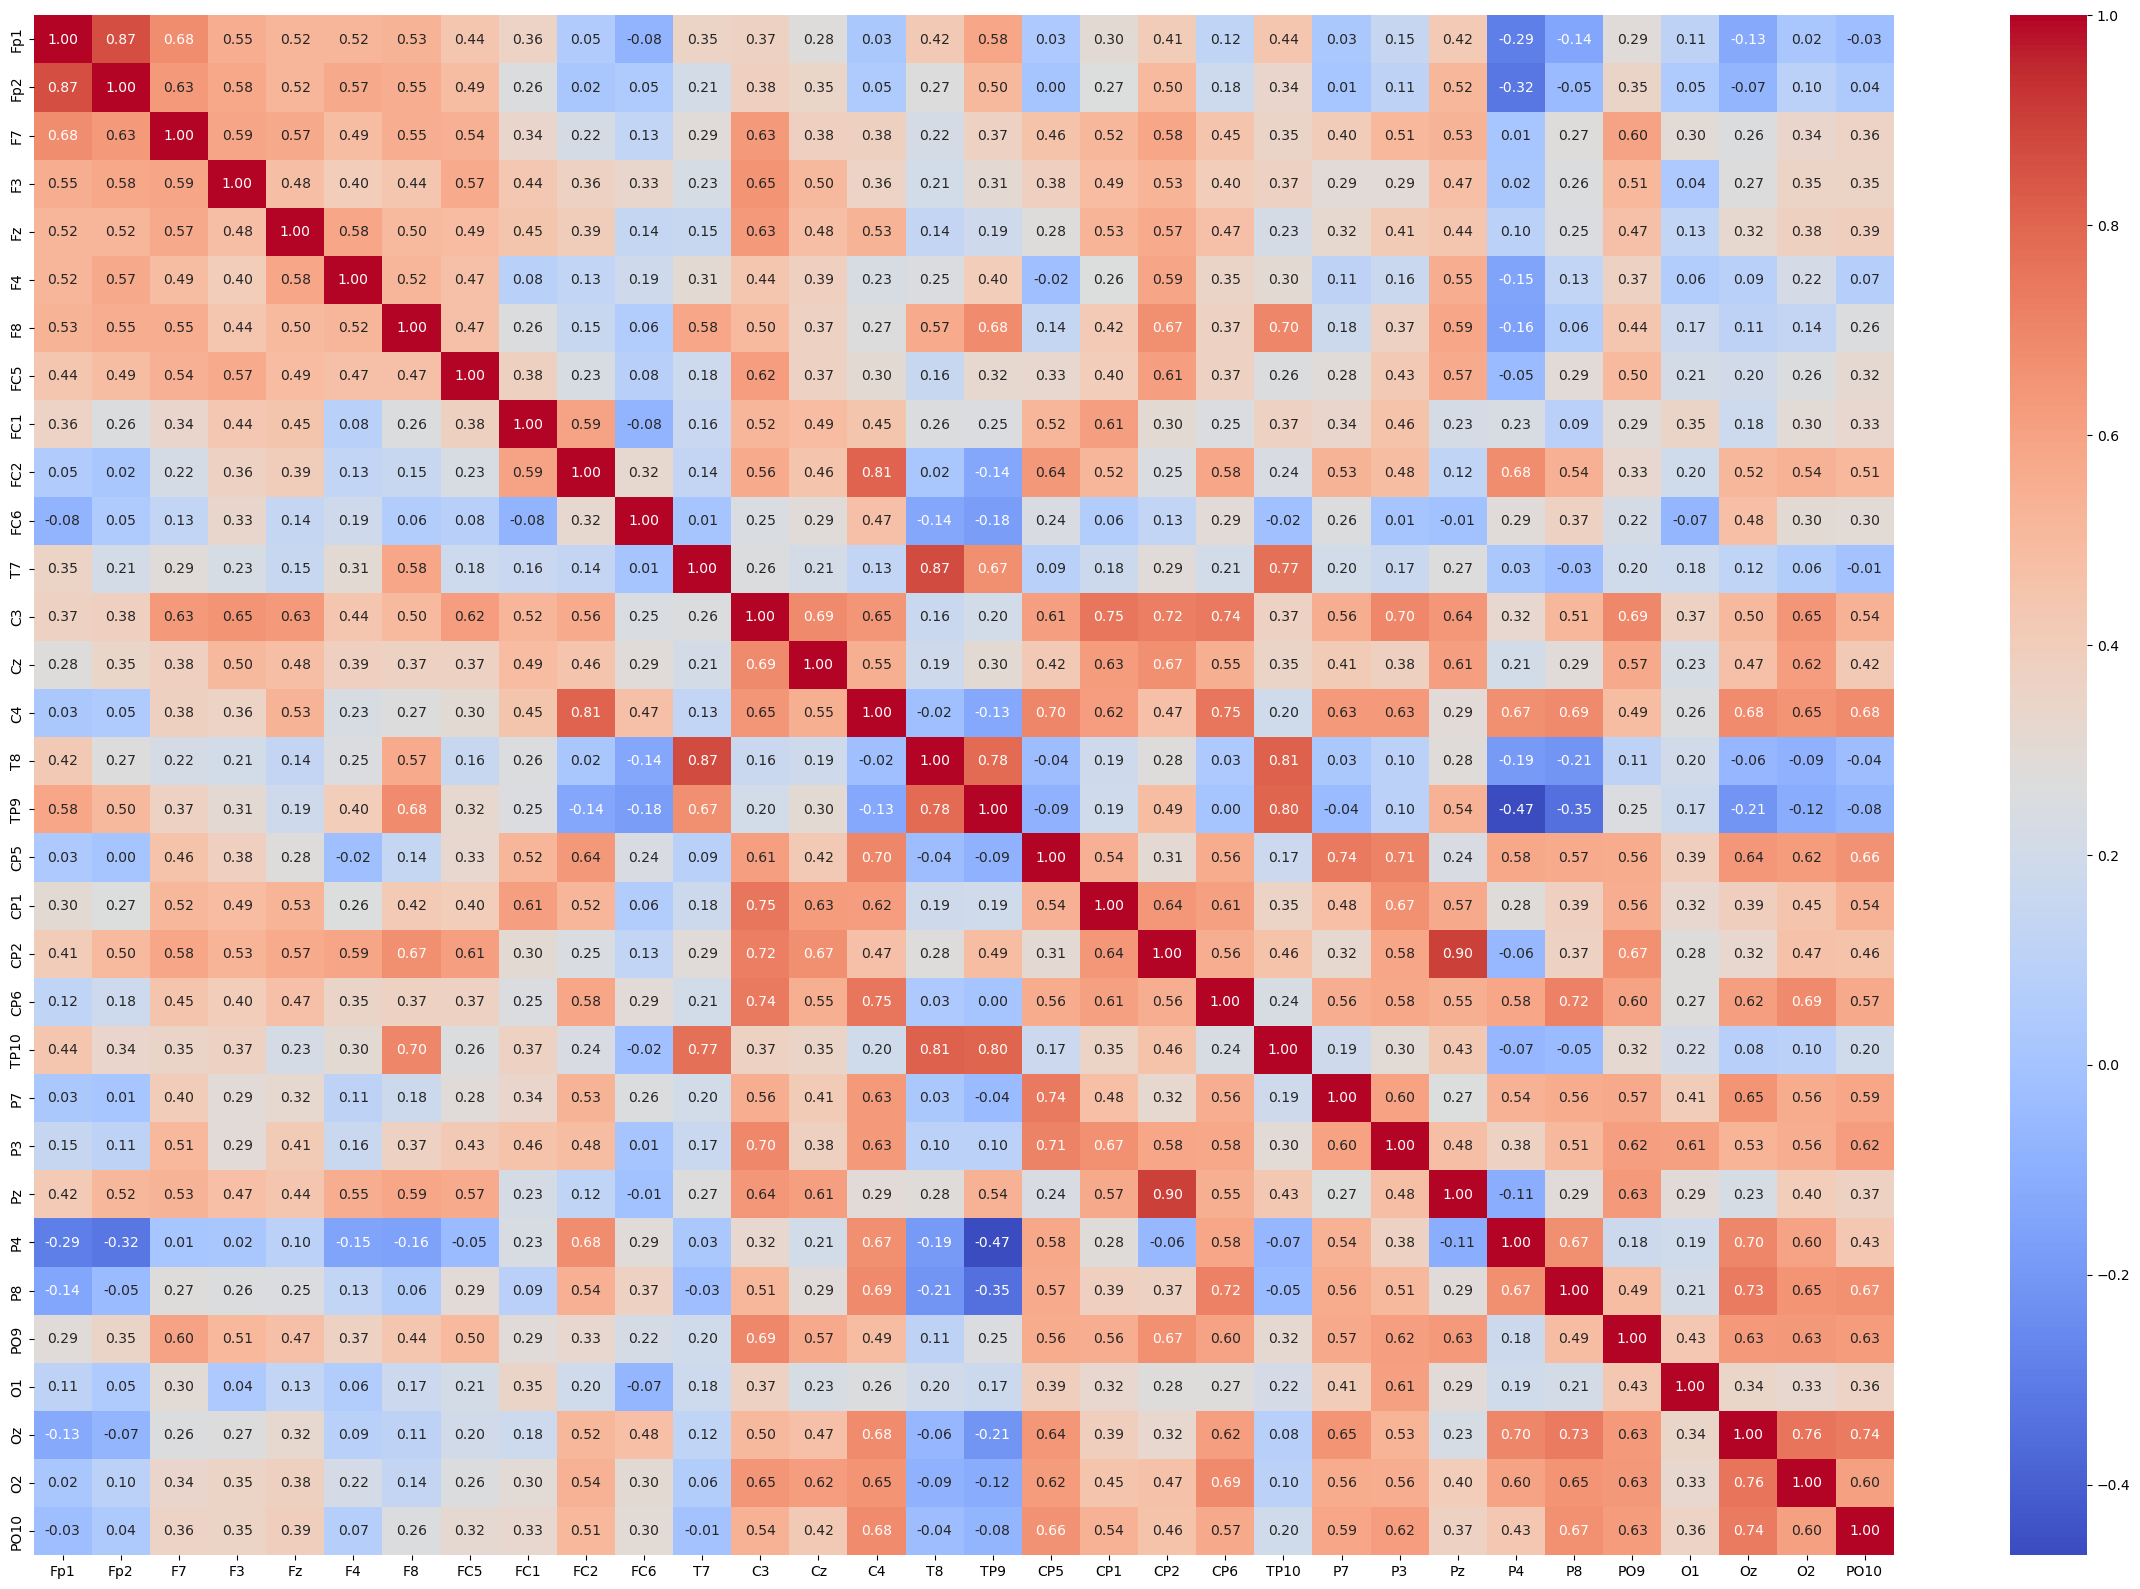

In [10]:
corr = features.drop(columns=['id']).corr()
plt.figure(figsize=(30, 20))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

## **Modeling**

### **Data Preprocessing**

In [27]:
def merge_labels(features, labels):
    data = features.copy()
    data = data.merge(labels, on='id')
    data.drop(columns=['id'], inplace=True)
    return data

def get_training_batch(series):
    features, labels = load_series_data(1, series)
    data = merge_labels(features, labels)
    for i in range(2, 13):
        features, labels = load_series_data(i, series)
        data = pd.concat([data, merge_labels(features, labels)])
    return data

In [28]:
train_df = get_training_batch(1)
train_df.shape, train_df.value_counts()

((2444189, 38),
 Fp1     Fp2    F7     F3    Fz    F4    F8     FC5   FC1   FC2   FC6   T7    C3     Cz    C4    T8     TP9   CP5   CP1   CP2   CP6   TP10  P7    P3    Pz    P4    P8    PO9   O1    Oz    O2    PO10  HandStart  FirstDigitTouch  BothStartLoadPhase  LiftOff  Replace  BothReleased
 -5662   -2331  -488    103   89   -212  -1106  -1    -80   -149  -569  -581  -49    -142  -451  -1060  -322  -257   68   -112  -472  -733  -235  -141  -48    62   -235  -126   28   -36   -97   -282  0          0                0                   0        0        0               1
  337     507    118   -67   -76   -241  -390    236   269   259   328   74    1477   284  -91   -48     12   -120   253   371   110   421   414   207   488   379   443   107   661   303   247   684  0          0                0                   0        0        0               1
          508    319   -372   120   515   255    442   380   26    162   186   279    27    166   235    106   100  -225   270  -120  -44

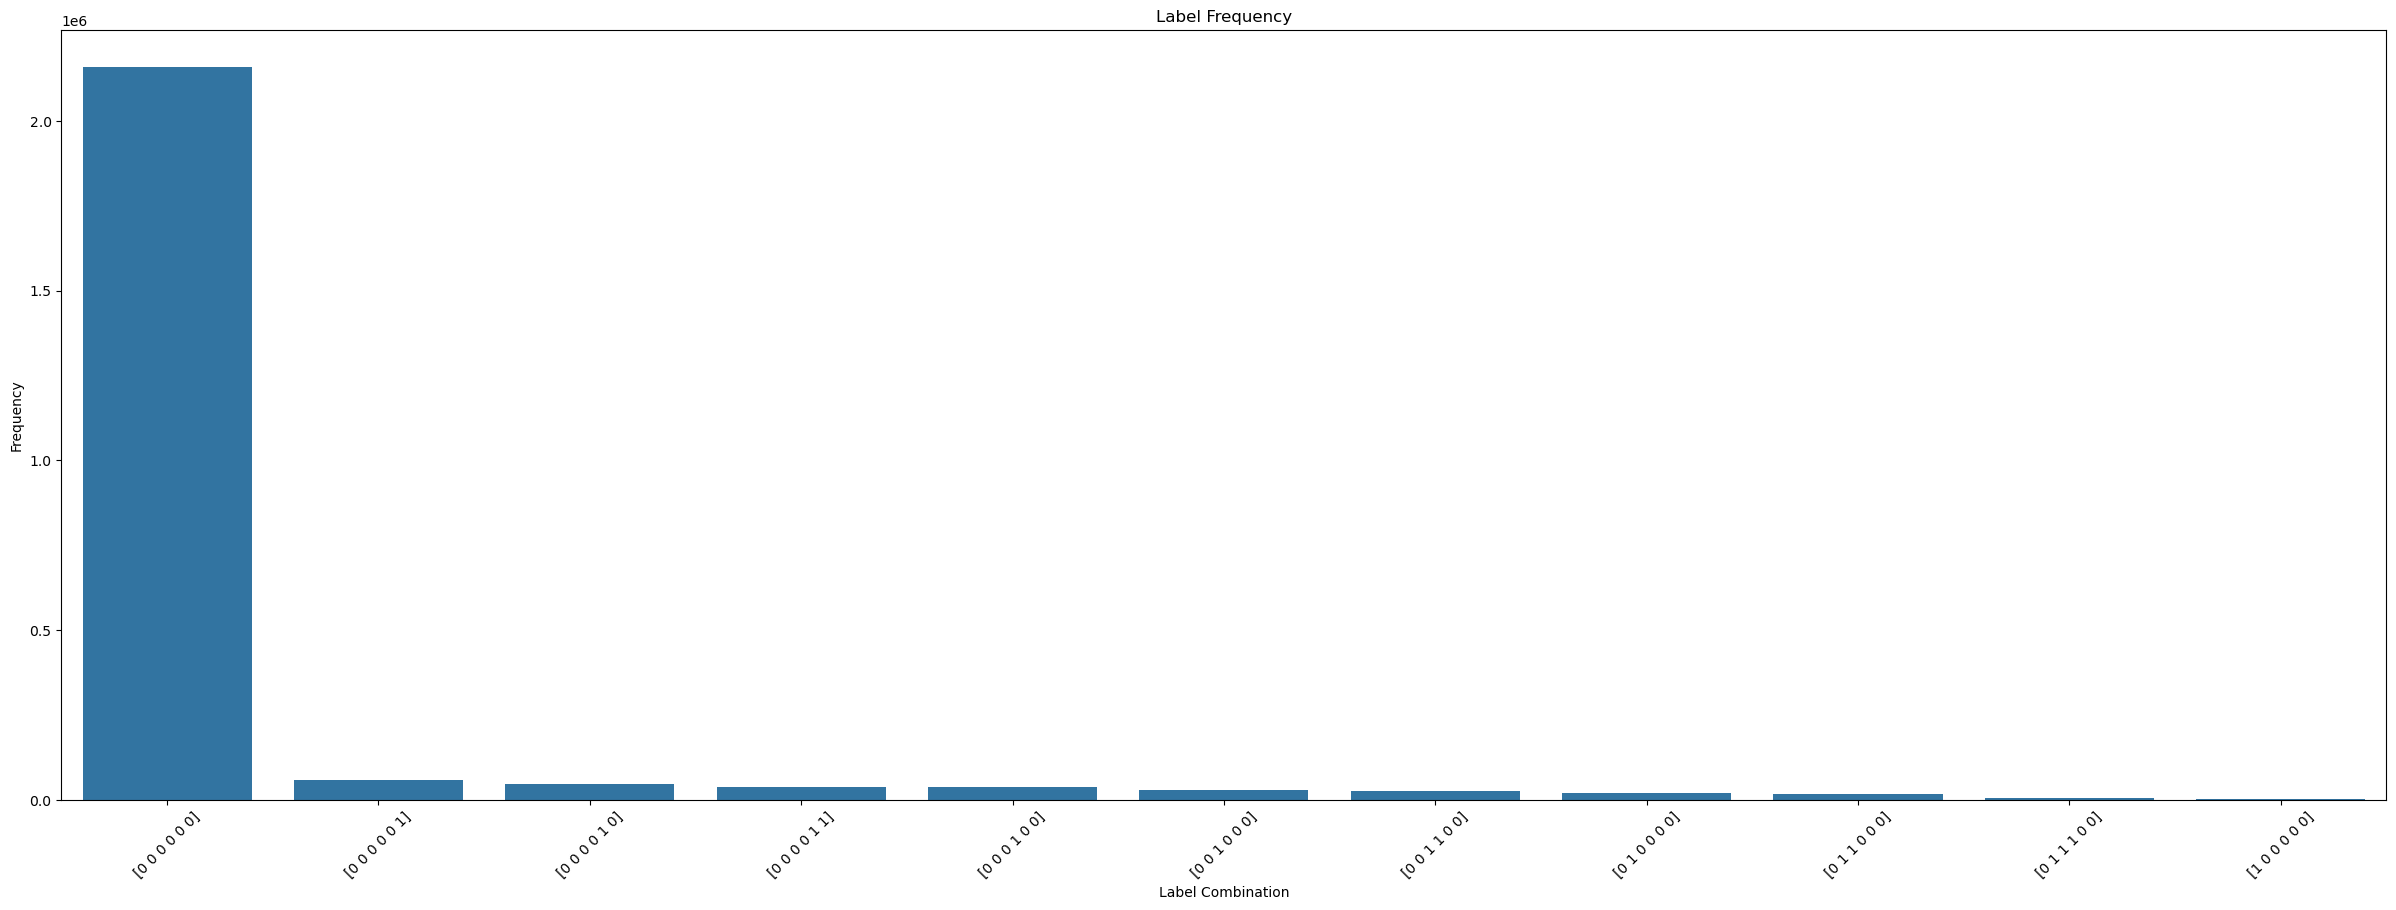

In [30]:
labels = train_df[['HandStart', 'FirstDigitTouch', 'BothStartLoadPhase', 'LiftOff', 'Replace', 'BothReleased']]
unique_label_combinations, counts = np.unique(labels, axis=0, return_counts=True)

plt.figure(figsize=(30, 10))
sns.barplot(x=range(len(unique_label_combinations)), y=counts, order=np.argsort(counts)[::-1])
plt.title('Label Frequency')
plt.xticks(range(len(unique_label_combinations)), unique_label_combinations, rotation=45)
plt.xlabel('Label Combination')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# reshape data for CSP
def reshape_data(data):
    X = data.drop(columns=['HandStart', 'FirstDigitTouch', 'BothStartLoadPhase', 'LiftOff', 'Replace', 'BothReleased']).values
    y = data[['HandStart', 'FirstDigitTouch', 'BothStartLoadPhase', 'LiftOff', 'Replace', 'BothReleased']].values
    y = y.astype(np.float64)
    X = np.expand_dims(X, axis=2)
    X = X.astype(np.float64)
    return X, y

X_train, y_train = reshape_data(train_df)
X_train = X_train.astype('float64').copy()
X_train.shape, y_train.shape, X_train.dtype, y_train.dtype

### **Model Building**

In [ ]:
def build_model(pipeline, param_grid, X_train, y_train, outer_cv=5, inner_cv=5):
    outer_cv = KFold(n_splits=outer_cv, shuffle=True, random_state=42)
    scores = []
    best_estimators = [] # Store a list of best estimators for each label
    best_scores = [] # Store a list of best scores for each label

    for train_index, test_index in outer_cv.split(X_train):
        X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
        
        # Initialize list to store best estimators and scores for each label in this outer fold
        fold_best_estimators = []
        fold_best_scores = []

        # Iterate over each label (column) in the multi-label target matrix
        for label_idx in range(y_train_fold.shape[1]):
            y_train_label = y_train_fold[:, label_idx]
            y_test_label = y_test_fold[:, label_idx]

            inner_cv = KFold(n_splits=inner_cv, shuffle=True, random_state=42)
            grid_search = GridSearchCV(pipeline, param_grid, cv=inner_cv, n_jobs=-1, verbose=1, scoring='accuracy') # You may change scoring to other suitable multi-label metrics
            grid_search.fit(X_train_fold, y_train_label)

            y_pred = grid_search.predict(X_test_fold)
            
            # Example: Calculate multiple metrics
            accuracy = accuracy_score(y_test_label, y_pred)
            jaccard = jaccard_score(y_test_label, y_pred, average='samples')  
            hamming = hamming_loss(y_test_label, y_pred)

            scores.append({'accuracy': accuracy, 'jaccard': jaccard, 'hamming': hamming}) 
            fold_best_estimators.append(grid_search.best_estimator_)
            fold_best_scores.append(jaccard)  

        best_estimators.append(fold_best_estimators)
        best_scores.append(fold_best_scores)
        

    best_label_indices = []
    for scores_per_fold in best_scores:
        best_label_indices.append(np.argmax(scores_per_fold))

    best_estimators_final = []
    for i in range(len(best_estimators)):  # Outer fold
        best_estimators_final.append(best_estimators[i][best_label_indices[i]])

    return best_estimators_final, scores  # Return a list of best estimators, one per label


#### Random Forest Model

In [ ]:
rf_clf = Pipeline([('CSP', CSP(n_components=4)),
                     ('RF', RandomForestClassifier())])

param_grid = {
    'CSP__n_components': [2, 4, 6],
    'RF__n_estimators': [50, 100, 200],
    'RF__max_depth': [10, 20, 30]
}

best_rf_clf, scores, best_rf_params = build_model(rf_clf, param_grid, X_train, y_train)
print("Grid search scores: ", scores)
rf_cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(best_rf_clf, X_train, y_train, cv=rf_cv, scoring='accuracy')
print("Cross-validation scores: ", scores)
print("Best RF parameters: ", best_rf_params)

#### Gradient Boosting Model

In [ ]:
gb_clf = Pipeline([('CSP', CSP(n_components=4)),
                        ('GB', GradientBoostingClassifier())])

param_grid = {
    'CSP__n_components': [2, 4, 6],
    'GB__n_estimators': [50, 100, 200],
    'GB__max_depth': [10, 20, 30]
}

best_gb_clf, scores, best_gb_params = build_model(gb_clf, param_grid, X_train, y_train)
print("Grid search scores: ", scores)
gb_cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(best_gb_clf, X_train, y_train, cv=gb_cv, scoring='accuracy')
print("Cross-validation scores: ", scores)
print("Best GB parameters: ", best_gb_params)

#### XGBoost Model

In [ ]:
xgb_clf = Pipeline([('CSP', CSP(n_components=4)), 
                        ('XGB', XGBClassifier())])

param_grid = {
    'CSP__n_components': [2, 4, 6],
    'XGB__n_estimators': [50, 100, 200],
    'XGB__max_depth': [10, 20, 30]
}

best_xgb_clf, scores, best_xgb_params = build_model(xgb_clf, param_grid, X_train, y_train)
print("Grid search scores: ", scores)
xgb_cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(best_xgb_clf, X_train, y_train, cv=xgb_cv, scoring='accuracy')
print("Cross-validation scores: ", scores)
print("Best XGB parameters: ", best_xgb_params)

### **Training Loop**

In [ ]:
def training_loop(model):
    total_test_x = pd.DataFrame()
    total_test_y = pd.DataFrame()
    for series in range(1, 9):
        train_df = get_training_batch(series)
        X_train, y_train = reshape_data(train_df)
        train_x, test_x, train_y, test_y = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
        model.fit(train_x, train_y)
        total_test_x = pd.concat([total_test_x, test_x])
        total_test_y = pd.concat([total_test_y, test_y])
        score = accuracy_score(total_test_y, model.predict(total_test_x))
        print(f"Series {series} score: {score}")
    y_pred = model.predict(total_test_x)
    accuracy = accuracy_score(total_test_y, y_pred)
    report = classification_report(total_test_y, y_pred)
    return accuracy, report, multilabel_confusion_matrix(total_test_y, y_pred)

### **Training and Evaluation**

#### Random Forest Model

In [ ]:
rf_accuracy, rf_report, rf_confusion_matrix = training_loop(best_rf_clf)
print(f"Random Forest accuracy: {rf_accuracy}")
print(rf_report)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(30, 10))

ConfusionMatrixDisplay(rf_confusion_matrix[0]).plot(ax=ax[0])
importances = best_rf_clf.feature_importances_
sns.barplot(x=range(len(importances)), y=importances, ax=ax[1])

plt.show()

#### Gradient Boosting Model

In [ ]:
gb_accuracy, gb_report, gb_confusion_matrix = training_loop(best_gb_clf)
print(f"Gradient Boosting accuracy: {gb_accuracy}")
print(gb_report)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(30, 10))

ConfusionMatrixDisplay(gb_confusion_matrix[0]).plot(ax=ax[0])
importances = best_gb_clf.feature_importances_
sns.barplot(x=range(len(importances)), y=importances, ax=ax[1])

plt.show()

#### XGBoost Model

In [ ]:
xgb_accuracy, xgb_report, xgb_confusion_matrix = training_loop(best_xgb_clf)
print(f"XGBoost accuracy: {xgb_accuracy}")
print(xgb_report)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(30, 10))

ConfusionMatrixDisplay(xgb_confusion_matrix[0]).plot(ax=ax[0])
plot_importance(best_xgb_clf, ax=ax[1])

plt.show()

## **Submission**
We're gonna download the testing data now from the Kaggle competition and unzip into the data directory.

In [ ]:
!kaggle competitions download grasp-and-lift-eeg-detection -f test.zip

In [ ]:
!unzip ../data/kaggle-eeg/test.zip -d ../data/kaggle-eeg

Here we load the sample submission from the Kaggle competition. This gives us a pre-made dataframe and we just need to update column values with predictions from our model. 

In [ ]:
!kaggle competitions download grasp-and-lift-eeg-detection -f sample_submission.csv.zip

In [ ]:
!unzip ../data/kaggle-eeg/sample_submission.csv.zip -d ../data/kaggle-eeg

In [31]:
sub = pd.read_csv('../data/kaggle-eeg/sample_submission.csv')

In [32]:
sub.head()

,id,HandStart,FirstDigitTouch,BothStartLoadPhase,LiftOff,Replace,BothReleased
0,subj1_series9_0,0,0,0,0,0,0
1,subj1_series9_1,0,0,0,0,0,0
2,subj1_series9_2,0,0,0,0,0,0
3,subj1_series9_3,0,0,0,0,0,0
4,subj1_series9_4,0,0,0,0,0,0


Here we create a dataframe in the same shape as the example submission on the competition page.

In [35]:
path = '../data/kaggle-eeg/test'

def get_merged_tests():
  tests = None
  for sj in range(1, 13):
    for sr in range(9, 11):
      c_tests = pd.read_csv(f'{path}/subj{sj}_series{sr}_data.csv')
      tests = c_tests if tests is None else pd.concat([tests, c_tests])
  return tests

In [36]:
tests = get_merged_tests()

In [37]:
tests = tests.drop(columns=['id'])
tests.head()

,Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,C3,Cz,C4,T8,TP9,CP5,CP1,CP2,CP6,TP10,P7,P3,Pz,P4,P8,PO9,O1,Oz,O2,PO10
0,66,213,347,212,-102,361,244,293,52,27,337,110,329,-48,241,114,-145,50,56,106,241,-170,327,113,15,262,449,-118,-25,88,10,119
1,85,178,297,156,-124,390,237,290,80,6,326,26,349,-65,195,371,-89,49,55,89,105,-139,340,119,7,219,388,-56,16,98,33,145
2,122,209,275,165,-130,380,245,199,63,4,355,95,343,-53,186,229,-78,91,47,76,53,-229,358,120,-2,201,313,-54,19,121,51,120
3,93,256,462,270,-124,352,239,236,77,15,390,189,349,-47,200,63,-57,117,66,110,149,-259,356,144,1,234,365,-34,27,127,66,163
4,-1,254,359,212,-139,351,237,235,74,11,335,176,378,-32,220,15,-22,120,95,131,233,-140,364,153,26,269,413,-84,5,101,22,174


In [ ]:
def get_predictions(model):
    data = tests.values
    data = np.expand_dims(data, axis=2)
    data = data.astype('float64')
    return model.predict(data)

In [ ]:
test_predictions_rf = get_predictions(best_rf_clf)
test_predictions_gb = get_predictions(best_gb_clf)
test_predictions_xgb = get_predictions(best_xgb_clf)

In [39]:
def create_submission(predictions, message):
    sub.iloc[:, 1:] = predictions
    sub.to_csv('../data/kaggl-eeg/submission.csv', index=False)
    submit_cmd = f'!kaggle competitions submit grasp-and-lift-eeg-detection -f ../data/kaggle-eeg/submission.csv -m "{message}"'
    return get_ipython().getoutput(submit_cmd)